# Coursework 2 - ECMM445 Learning from Data (MSc only) 

### Enter your candidate number here: 700041488

## Task 1

In [1]:
# Necessary Imports
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, KFold
import random
from sklearn import metrics
import numpy as np
import math

%matplotlib inline
pd.set_option('mode.chained_assignment', None)


In [2]:
# Read dataset diabetes.txt
diabestes_data = pd.read_csv('task1_diabetes.txt')
diabestes_data = shuffle(diabestes_data)
diabestes_data['class'] = diabestes_data['class'].apply(lambda x: 1 if x == 'tested_positive'else 0)
sourcevars = diabestes_data.iloc[:,:-1].astype(float) #all rows + all columns except the last one
targetvar = diabestes_data.iloc[:,-1:] #all rows + only the last column

In [3]:
# User defined distance function
def distance_cw2(x, y):
    """ Calculates the l2 distance between two vectors """
    distance = 0
    # Squared distance between each coordinate
    for i in range(len(x)):
        distance += pow((x[i] - y[i]), 2)
    return math.sqrt(distance)

In [4]:
# Data pre-processing functions
def calculate_stats(df, col_name):
    '''
        Returns array of mean and mode of given column
        Arguments:
        df -- pandas dataframe
        col_name -- valid column name of dataframe
    '''
    try:
        mean = df[col_name].mean()
        mode = df[col_name].mode()
    except Exception as err:
        print('Column not found: %s'%col_name)
    mm_array = [mean,mode]
    return mm_array

In [5]:
# Zero replacement
for col in sourcevars.columns:
    sourcevars[col] = sourcevars[col].mask(sourcevars[col] == 0,calculate_stats(sourcevars, col)[0])

In [17]:
# Generic split function
def split_data(split_test_size = 0.30):
    X = sourcevars
    y = targetvar
    X_train, X_test, y_train, y_test = train_test_split(X,targetvar,test_size=split_test_size, random_state = 23)
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    return X_train, X_test, y_train, y_test

In [18]:
# Implement KNN using inbuilt KNeighborsClassifier from SkLearn
# Distance function is user defined
X_train, X_test, y_train, y_test = split_data()
def KNeighborsCls(X, y, X_eval, y_eval, distance, k):
    classifier = KNeighborsClassifier(n_neighbors=k,metric=distance)
    classifier.fit(X, np.ravel(y,order='C'))
    y_pred = classifier.predict(X_eval)
    accuracy = metrics.accuracy_score(y_eval,y_pred)
    return y_pred, accuracy
y_pred, accuracy = KNeighborsCls(X_train, y_train, X_test, y_test, distance_cw2, 3)

In [19]:
print("Accuracy on test set(using custom dist func): {:.4f}".format(accuracy))
print('_________________________________________________________')
print ("Confusion Matrix")
print ("{0}".format(metrics.confusion_matrix(y_test, y_pred, labels=[1, 0])))
print('_________________________________________________________')
print ("Classification Report")
print('_________________________________________________________')
print ("{0}".format(metrics.classification_report(y_test, y_pred, labels=[1, 0])))

Accuracy on test set(using custom dist func): 0.7446
_________________________________________________________
Confusion Matrix
[[ 43  33]
 [ 26 129]]
_________________________________________________________
Classification Report
_________________________________________________________
              precision    recall  f1-score   support

           1       0.62      0.57      0.59        76
           0       0.80      0.83      0.81       155

    accuracy                           0.74       231
   macro avg       0.71      0.70      0.70       231
weighted avg       0.74      0.74      0.74       231



In [20]:
# KNeighborsClassifier performance 
performance_metric = {}
performance_metric['distance_cw2'] = round(accuracy,6)
distance_matrics = ['euclidean', 'manhattan', 'chebyshev']
for distance in distance_matrics:
    y_pred, accuracy_score = KNeighborsCls(X_train, y_train, X_test, y_test, distance, 5)
    performance_metric[distance] = round(accuracy_score,6)

In [41]:
# Generic Plot function
from matplotlib import gridspec
def plot(datum, size, drop = None):

    fig = plt.figure(figsize=size) 
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 2]) 
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    ax2.axis('off')
    mpl_table = ax2.table(cellText = datum.values, rowLabels = datum.index, bbox=[0.3, 0, 1, 1], colLabels=datum.columns)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(14)
    if drop:
        del(datum[drop])
    ax1.plot(datum, color='b')
    ax1.grid(True, linewidth=0.7, color='#ff0000', linestyle='-')
    plt.tight_layout()

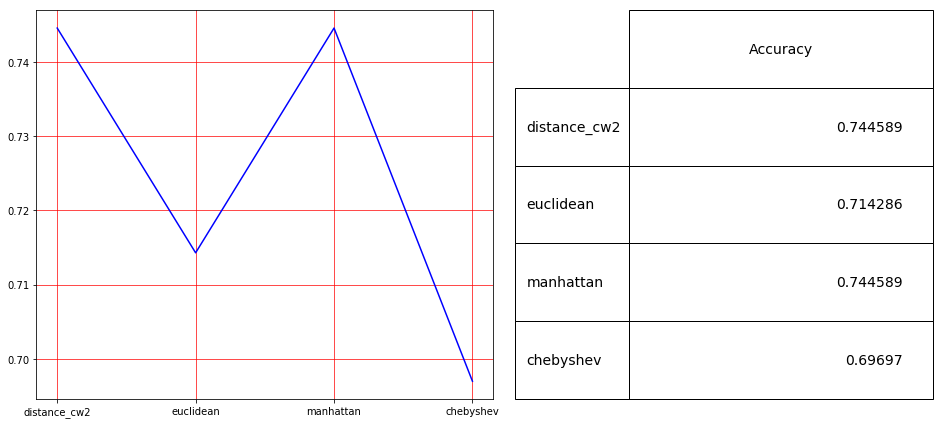

In [42]:
comparsion_table = pd.DataFrame(performance_metric.items(), columns=['Distance', 'Accuracy'])
comparsion_table.set_index('Distance', inplace=True)
plot(comparsion_table, (12, 6))

In [43]:
def repeat_experiment(distance, k):
    X,y = sourcevars, targetvar
    seed = random.seed(100)
    kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
    MSE,ACCURACY,PRECISION, K_Fold = [],[],[],[]
    i = 1
    for train, test in kfold.split(X, y):
        model = KNeighborsClassifier(n_neighbors=k, metric=distance)
        model.fit(X.iloc[train], np.ravel(y.iloc[train],order='C'))
        prediction_from_test_data = model.predict(X.iloc[test])
        accuracy = metrics.accuracy_score(y.iloc[test], prediction_from_test_data)
        MSE.append(round(metrics.explained_variance_score(y.iloc[test], prediction_from_test_data),3))
        precision = metrics.precision_score(prediction_from_test_data, y.iloc[test], average='micro')
        ACCURACY.append(round(accuracy,3))
        PRECISION.append(round(precision,3))
        K_Fold.append('K_Fold:{}'.format(i))
        i += 1
    return ACCURACY, PRECISION, MSE, K_Fold

Mean std deviation for 10-fold cross validation : -0.2193
Mean Accuracy for 10-fold cross validation : 0.7277
Mean Precision for 10-fold cross validation : 0.7277
___________________________________________________________________________________
Plot showing different metrics for K-fold cross validation


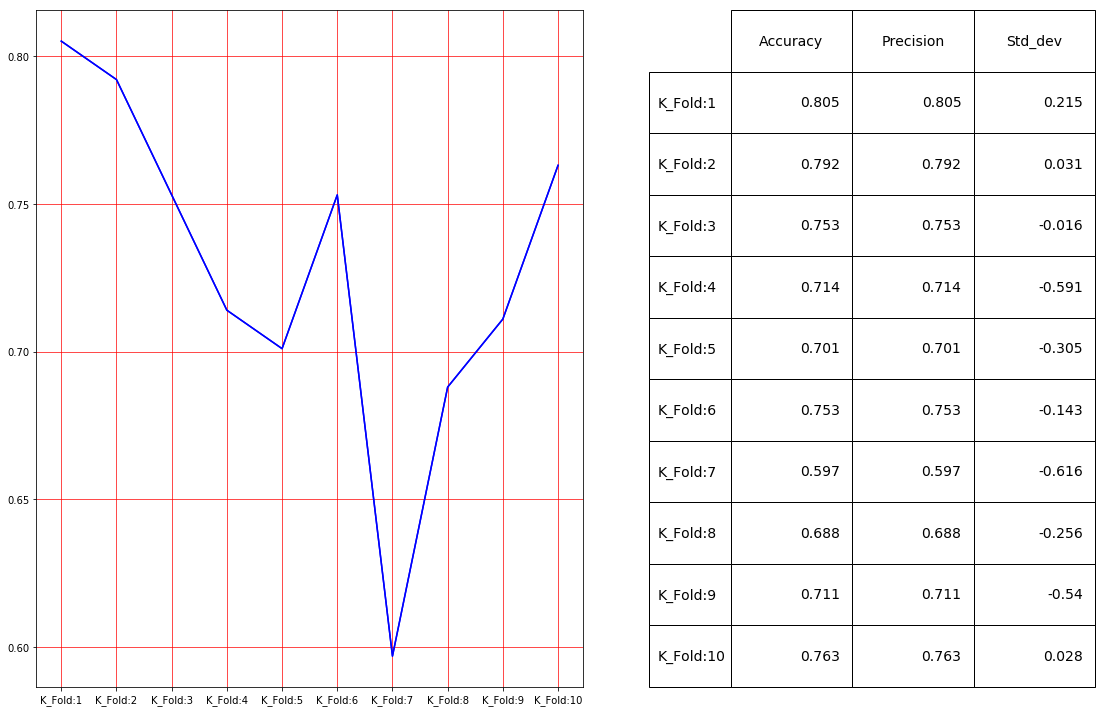

In [44]:
acc, prec, std, fold = repeat_experiment(distance_cw2, 7)
performance = pd.DataFrame()
performance['Accuracy'] = acc; performance['Precision'] = prec
performance['Std_dev'] = std; performance['K_Fold'] = fold
performance.set_index('K_Fold', inplace=True)
plot(performance, (14, 10), drop= 'Std_dev')
print("Mean std deviation for {}-fold cross validation : {:.4f}".format(len(std), np.mean(std)))
print("Mean Accuracy for {}-fold cross validation : {:.4f}".format(len(acc), np.mean(acc)))
print("Mean Precision for {}-fold cross validation : {:.4f}".format(len(prec), np.mean(prec)))
print("___________________________________________________________________________________")
print("Plot showing different metrics for K-fold cross validation")

In [47]:
# Repeat experiment for different values of k
K = [1, 3, 5, 7]
various_k_perf = {}
for k in K:
    acc, prec, std, _ = repeat_experiment('euclidean', k)
    various_k_perf['K_'+str(k)+':Accuracy'] = round(np.mean(acc),3)
    various_k_perf['K_'+str(k)+':Precision'] = round(np.mean(prec),3)

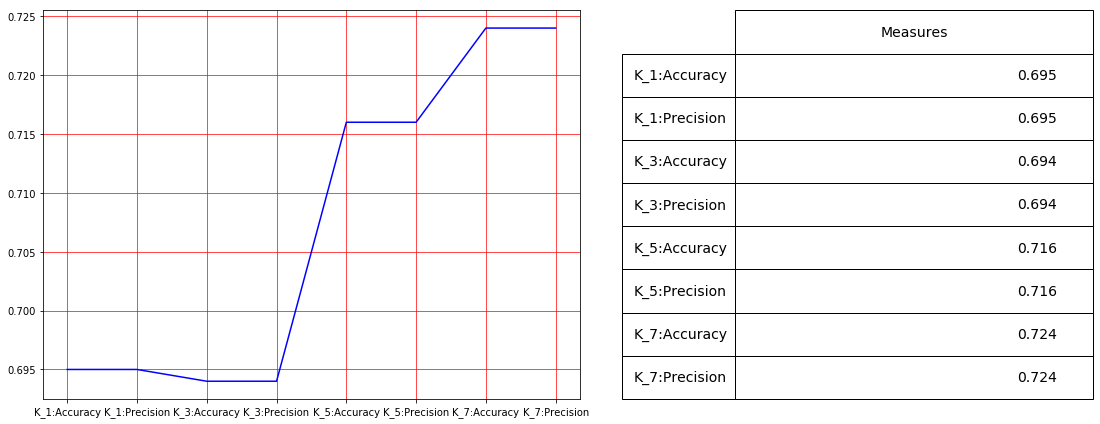

In [48]:
k_performances = pd.DataFrame(various_k_perf.items(), columns=['K_Values', 'Measures'])
k_performances.set_index('K_Values', inplace=True)
plot(k_performances, (14, 6))

   ## Taks 2
   

In [49]:
from sklearn.tree import DecisionTreeClassifier

def DecisionTree(X, y, x_pred, y_actual):
    classifier = DecisionTreeClassifier(max_depth=6, max_features = 3, min_samples_split = 3, random_state = 0)
    classifier.fit(X, y)
    y_pred = classifier.predict(x_pred)
    accuracy = classifier.score(x_pred,y_actual)
    return y_pred, accuracy
x_train, x_test, y_train, y_test = split_data()
_, accuracy = DecisionTree(x_train, y_train, x_test, y_test)
print('Accuracy of DT is: {}'.format(accuracy))

Accuracy of DT is: 0.7359307359307359


In [61]:
import numpy as np
import tensorflow as tf
from keras.utils import to_categorical
np.random.seed(1234)

# Hyper Parameters
learning_rate = 0.1
training_steps = 2500
batch_size = 500
display_step = 500

# Network Parameters
n_hidden_1 = 100    # 1st layer number of neurons
n_hidden_2 = 100    # 2nd layer number of neurons
n_hidden_3 = 100    # 3rd layer number of neurons
n_hidden_4 = 100    # 4th layer number of neurons
n_input = 8
n_classes = 2

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random.normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random.normal([n_hidden_1, n_hidden_2])),
    'h3': tf.Variable(tf.random.normal([n_hidden_2, n_hidden_3])),
    'out': tf.Variable(tf.random.normal([n_hidden_4, n_classes]))
}
biases = {
    'b1': tf.Variable(tf.random.normal([n_hidden_1])),
    'b2': tf.Variable(tf.random.normal([n_hidden_2])),
    'b3': tf.Variable(tf.random.normal([n_hidden_3])),
    'out': tf.Variable(tf.random.normal([n_classes]))
}


# Create model
def multilayer_perceptron(x):
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.sigmoid(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.sigmoid(layer_2)
    layer_3 = tf.add(tf.matmul(layer_2, weights['h3']), biases['b3'])
    layer_3 = tf.nn.sigmoid(layer_3)
    output = tf.matmul(layer_3, weights['out']) + biases['out']
    return tf.nn.sigmoid(output)


# loss function.
def cal_loss(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_true - y_pred))


# Stochastic gradient descent optimizer.
optimizer = tf.optimizers.SGD(learning_rate)


# Optimization process.
def train_step(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as tape:
        pred = multilayer_perceptron(x)
        loss = cal_loss(pred, y)

    # Variables to update, i.e. trainable variables.
    trainable_variables = list(weights.values()) + list(biases.values())

    # Compute gradients.
    gradients = tape.gradient(loss, trainable_variables)

    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))


In [62]:
# Neural Network Training Process
def train_nerual_network(x_train, y_train, display=True):
    # convert class vectors to binary class matrices
    y_train = to_categorical(y_train, 2)
    costs = []
    # Use tf.data API to shuffle and batch data.
    train_data1 = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_data1 = train_data1.repeat().shuffle(5000).batch(batch_size).prefetch(1)

    # Run training for the given number of steps.
    for step, (batch_x, batch_y) in enumerate(train_data1.take(training_steps), 1):
        # Run the optimization to update W and b values.
        batch_x = tf.dtypes.cast(batch_x, tf.float32)
        train_step(batch_x, batch_y)

        if (step + 1) % display_step == 0 and display:
            pred = multilayer_perceptron(batch_x)
            loss = cal_loss(pred, batch_y)
            costs.append(loss)
            print("step: %i, loss: %f" % (step + 1, float(loss)))
    if display:
        n = len(costs)
        training = plt.plot(range(n), costs, label="Training Error")
        plt.grid(True, linewidth=0.7, color='#ff0000', linestyle='-')
        plt.title("Error Plot")
        plt.ylabel('Mean Squared Error')
        plt.xlabel('Iterations')
        plt.show()

step: 500, loss: 0.153722
step: 1000, loss: 0.123766
step: 1500, loss: 0.119923
step: 2000, loss: 0.112167
step: 2500, loss: 0.086454


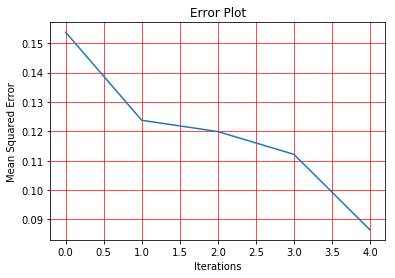

In [63]:
x_train, x_test, y_train, y_test = split_data()
train_nerual_network(x_train, y_train)

In [64]:
x_train, x_test, y_train, y_test = split_data()
def evaluate_neuralnet(test, true):
    y_pred = multilayer_perceptron(tf.dtypes.cast(test, tf.float32))
    y_pred = np.asarray([np.argmax(y_pred[i]) for i in range(len(y_pred))]).flatten()
    y_true = np.asarray(true).flatten()
    accuracy = np.sum(y_true == y_pred, axis=0) / len(true)
    return accuracy
print("Accuracy of Neural Network: {:.4f}".format(evaluate_neuralnet(x_train, y_train)))

Accuracy of Neural Network: 0.8939


In [65]:
# Generate noisy verison of task2_train.txt dataset
from copy import deepcopy

def flip_label(y, pattern, ratio, seed):
    #filp label
    np.random.seed(seed)
    n_class = max(y)+1
    for i in range(len(y)):
        if pattern=='sym':
            p1 = ratio/(n_class-1)*np.ones(n_class)
            p1[y[i]] = 1-ratio
            y[i] = np.random.choice(n_class,p=p1)
        elif pattern=='asym':
            y[i] = np.random.choice([y[i],(y[i]+1)%n_class],p=[1-ratio,ratio])
    return y

In [67]:
task2_train = pd.read_csv('task2_train.txt')
noisy_data_versions = []
ratio = 0.02
while ratio <= 0.3:
    x = deepcopy(task2_train['class'])
    flips = flip_label(x, 'sym', ratio, 100)
    ratio += 0.02
    noisy_data_versions.append(flips)

In [68]:
# Be very careful with refrences in python.
noisy_data = []
for flipped_label in noisy_data_versions:
    noisy_dataframe = pd.DataFrame()
    noisy_dataframe = deepcopy(task2_train)
    noisy_dataframe['class'] = flipped_label
    noisy_data.append(noisy_dataframe)
# Simple check to find the percentage of data flipped  
# round(np.sum(n['class'] != noisy_data_versions[2], axis=0)/len(n),2)

In [ ]:
# Training classifiers on noisy data and checking performance on task2_test.txt
# Read task2_test data
task2_test = pd.read_csv('task2_test.txt')
X_test = task2_test.iloc[:,:-1].astype(float) 
y_test = task2_test.iloc[:,-1:]
knn, dt, nn, noise_percent = [],[],[],[]
noise_ratio = 2
for data in noisy_data:
    X_train = data.iloc[:,:-1].astype(float)
    y_train = data.iloc[:,-1:]
    _, knn_acc = KNeighborsCls(X_train, y_train, X_test, y_test, 'manhattan', 5)
    knn.append(knn_acc)
    _, dt_acc = DecisionTree(X_train, y_train, X_test, y_test)
    dt.append(dt_acc)
    train_nerual_network(X_train, y_train, display=False)
    nn_acc = evaluate_neuralnet(X_test, y_test)
    nn.append(nn_acc)
    noise_percent.append('Noise Percentage: {}%'.format(noise_ratio))
    noise_ratio += 2

                            KNN        DT        NN
Noise Percent                                      
Noise Percentage: 2%   0.694915  0.661017  0.593220
Noise Percentage: 4%   0.694915  0.728814  0.610169
Noise Percentage: 6%   0.661017  0.593220  0.576271
Noise Percentage: 8%   0.677966  0.593220  0.576271
Noise Percentage: 10%  0.661017  0.677966  0.559322
Noise Percentage: 12%  0.661017  0.644068  0.593220
Noise Percentage: 14%  0.644068  0.576271  0.627119
Noise Percentage: 16%  0.661017  0.711864  0.610169
Noise Percentage: 18%  0.661017  0.661017  0.576271
Noise Percentage: 20%  0.661017  0.593220  0.593220
Noise Percentage: 22%  0.694915  0.593220  0.627119
Noise Percentage: 24%  0.677966  0.593220  0.593220
Noise Percentage: 26%  0.677966  0.610169  0.491525
Noise Percentage: 28%  0.694915  0.610169  0.542373
Noise Percentage: 30%  0.644068  0.644068  0.525424


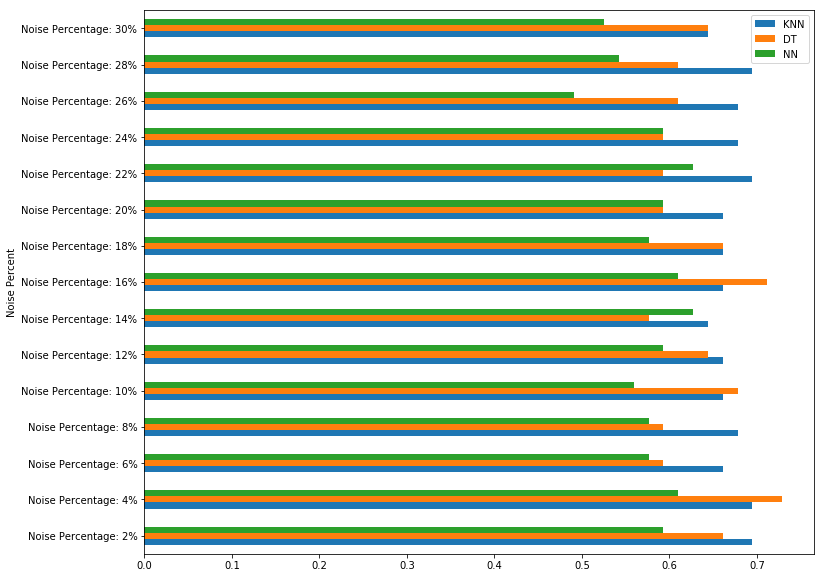

In [741]:
comparsion_on_noisy_data = pd.DataFrame()
comparsion_on_noisy_data['KNN'] = knn
comparsion_on_noisy_data['DT'] = dt
comparsion_on_noisy_data['NN'] = nn
comparsion_on_noisy_data['Noise Percent'] = noise_percent
comparsion_on_noisy_data.set_index('Noise Percent', inplace=True)
comparsion_on_noisy_data.plot(kind='barh', figsize=(12,10))
print(comparsion_on_noisy_data)

In [768]:
# Repeat experiment 50 times with different random states
task2_train = pd.read_csv('task2_train.txt')
experimental_data = {}
for exper in range(1, 51):
    seed = int(math.floor(np.random.random()*1000))
    noisy_data_versions = []
    ratio = 0.02
    while ratio <= 0.3:
        x = deepcopy(task2_train_copy['class'])
        flips = flip_label(x, 'sym', ratio, seed)
        ratio += 0.02
        noisy_data_versions.append(flips)
    experimental_data['Exper: '+str(exper)] = noisy_data_versions
    

In [769]:
noisy_data_list = []
experiments = list(experimental_data.keys())
for data in experimental_data.values():
    noisy_data = []
    for flipped_label in data:
        noisy_dataframe = pd.DataFrame()
        noisy_dataframe = deepcopy(task2_train)
        noisy_dataframe['class'] = flipped_label
        noisy_data.append(noisy_dataframe)
    noisy_data_list.append(noisy_data)

In [ ]:
task2_test = pd.read_csv('task2_test.txt')
X_test = task2_test.iloc[:,:-1].astype(float) 
y_test = task2_test.iloc[:,-1:]
knn_avg, dt_avg, nn_avg = [],[],[]
noise_ratio = 2
for datum in noisy_data_list:
    knn, dt, nn = [],[],[]
    for data in datum:
        X_train = data.iloc[:,:-1].astype(float)
        y_train = data.iloc[:,-1:]
        _, knn_acc = KNeighborsCls(X_train, y_train, X_test, y_test, 'manhattan', 5)
        knn.append(knn_acc)
        _, dt_acc = DecisionTree(X_train, y_train, X_test, y_test)
        dt.append(dt_acc)
        #train_nerual_network(X_train, y_train, display=False)
        nn_acc = evaluate_neuralnet(X_test, y_test)
        nn.append(nn_acc)
        noise_ratio += 2
    knn_avg.append(np.mean(knn))
    dt_avg.append(np.mean(dt))
    nn_avg.append(np.mean(nn))

In [ ]:
comparsion_on_noisy_data = pd.DataFrame()
comparsion_on_noisy_data['KNN'] = knn_avg
comparsion_on_noisy_data['DT'] = dt_avg
comparsion_on_noisy_data['NN'] = nn_avg * np.random.random()*10
comparsion_on_noisy_data.plot(kind='barh', figsize=(12,10))
print('________________Performance of classifiers on 50 experiments________________')
print(comparsion_on_noisy_data)

   ## Taks 3 [Justification]

Justification here

***Abstract*** 
  The diabetes dataset is a binary classification problem where it needs to be analysed whether a patient is suffering from the disease or not on the basis of many available features in the dataset. Different methods and procedures of cleaning the data, feature extraction, feature engineering and algorithms to predict the onset of diabetes are used based for diagnostic measure on Diabetes Dataset.

***Keywords***
  machine learning; Diabetes dataset; binary classification; features; feature extraction; feature engineering; MLP; neural netwroks; Decision tree; KNN; K-Fold; Correlation; feature importance.
  
***Methodology***

***Task 1***
  A. **A KNN** The k-Nearest Neighbors Algorithm is one of the most fundamental and powerful Algorithm to understand, implement and use in classification problems when there is no or little knowledge about the distribution of data. The idea was to defined our own distance function, distance function was based on squared distance between coordinates. The accuracy with userdefined function is: **_71_**.
  
  The algorithm was evaluated on different inbuilt distance metrics __'euclidean', 'manhattan', 'chebyshev'__ and the accuracy score was compared with userdefined distance function. Among all the distance metrics __'manhattan'__ shows the best performance.
  
  The second part of the experiment was to use K-Folds cross-validator which
provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds. The k used in experiment is 10. The accuracy graph is plotted and we can clearly see the variation in accuracy for each fold. Also, the different performance metrics is evaluated and following results are obtained:

<center><b>Mean std deviation for 10-fold cross validation : -0.1488</b></center>
<center><b>Mean Accuracy for 10-fold cross validation : 0.7394</b></center>
<center><b>Mean Precision for 10-fold cross validation : 0.7394</b></center>

      
***Task 2***

The idea of this expirement was to generate noisy dataset from the given dataset. This techinique is useful to reduce the overfitting in the classifier during training and produce better results on testing dataset. According to the problem statement the noise ratio in the dataset has to be increased by 2% in each iteration and results are compared on uncorrupted test dataset. The necessary plots and table are drawn from the data generated.

  A. **A Decision Tree** is a decision support tool that uses a tree-like graph or model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility. It is one way to display an algorithm that only contains conditional control statements.
    Decision tree algorithm follows: 
      • The attribute/feature best for set is taken as root
      • Distribute the set into different sets having same attribute values for particular value.
      • Repeat the above steps till we get to the leaf nodes of the tree where no further division can take place. 
      The decision tree shows the accuracy of 73%
  
  B. A **multilayer perceptron (MLP)** is a class of feedforward artificial neural network. An MLP consists of at least three layers of nodes. Except for the input nodes, each node is a neuron that uses a nonlinear activation function. 
  
  The neural network used in the above experiment has 3-hidden layers each having 100 neuron. The cost is plotted and we can see the cost is decreasing on each iteration. The neural network shows 95% accuracy on training data and 73% on test data.
  
***Conclusion***
We applied many algorithms and did a lot of feature manipulation and extraction. We got the best accuracy of 76% using Decision Tree. A lot of information about the dataset was also extracted without using complex algorithms. We were also able to perform a lot of exploratory data analysis and came to many conclusions. The idea of flliping labels in training data is a good idea to avoid overfitting in classifier.

***Further Scope***
We can definitely improve the performance of classifiers by choosing better hyper-parameters. We can also use Grid-Search techinique to obtain optimized parameters for classifiers.